# Setup a Panelled Radiation Pressure Model
## Objectives
This example demonstrates how to setup a panelled radiation pressure model (sometimes also called n-plate model) for a simple box-wing satellite.

The example introduces the basic steps that are required to define a plated radiation pressure target model. It showcases the different options that are available to define plate geometries available in the [vehicle_systems](https://py.api.tudat.space/en/latest/vehicle_systems.html) module and specify their radiative properties from the [radiation_pressure](https://py.api.tudat.space/en/latest/radiation_pressure.html) module.
A cannonball target model is created along-side the plated model to highlight the differences between the two model setups.

## Pre-Requisites
This examples assumes that you are familiar with the necessary steps how to setup a simple orbit propagation in Tudat.
If you would like to revisit these steps, take a look at the [Keplerian orbit propagation example](https://docs.tudat.space/en/latest/_src_getting_started/_src_examples/tudatpy-examples/propagation/keplerian_satellite_orbit.html) and in particular the [perturbed orbit propagation example](https://docs.tudat.space/en/latest/_src_getting_started/_src_examples/tudatpy-examples/propagation/perturbed_satellite_orbit.html).

## Import statements and SPICE setup

In [1]:
# Load standard modules
import numpy as np

from matplotlib import pyplot as plt

# Load tudatpy modules
from tudatpy.interface import spice
from tudatpy import dynamics
from tudatpy.dynamics import environment
from tudatpy.dynamics import environment_setup, propagation_setup, simulator
from tudatpy.util import result2array
from tudatpy.astro.time_representation import DateTime

# Load spice kernels
spice.load_standard_kernels()

## Environment setup
Let’s create the environment for our simulation. In this example an Earth-orbiting spacecraft will be modelled, following the previous examples.
Since we will also consider the radiation pressure acceleration by the Sun, we will create both the Sun and the Earth using the default settings.

Note that the default radiation source model assigned to the Sun is based on a constant luminosity, as listed in the [default environment models](https://docs.tudat.space/en/latest/_src_user_guide/state_propagation/environment_setup/default_env_models.html#radiation-source). Other options for solar radiation pressure as well as planetary radiation pressure exist, see the [radiation source models](https://docs.tudat.space/en/latest/_src_user_guide/state_propagation/propagation_setup/translational/radiation_pressure_acceleration.html#radiation-source-models) section in the user guide.

In [2]:
# Define string names for bodies to be created from default.
bodies_to_create = ["Sun", "Earth"]

# Use "Earth"/"J2000" as global frame origin and orientation.
global_frame_origin = "Earth"
global_frame_orientation = "J2000"

# Create default body settings
body_settings = environment_setup.get_default_body_settings(
    bodies_to_create, global_frame_origin, global_frame_orientation
)

### Create the vehicle
Two vehicle settings will be created from empty settings:

- `Delfi-CB` will be setup with a cannonball target model
- `Delfi-NP` will be setup with a plated (n-plate) target model

In [3]:
# Create empty body settings for the satellite
body_settings.add_empty_settings("Delfi-CB")
body_settings.add_empty_settings("Delfi-NP")

## Create the cannonball target model settings

The cannonball target model settings are created analogously as in the [perturbed orbit propagation example](https://docs.tudat.space/en/latest/_src_getting_started/_src_examples/tudatpy-examples/propagation/perturbed_satellite_orbit.html).

The dimensions of a typical 3U cubesat are assumed, with an added solar-panel, that is always pointing at the Sun.

In [4]:
L = 0.3
W = 0.1
H = 0.1
radiation_pressure_coefficient = 1.5

# Average projection area of a 3U CubeSat + Solar panel
reference_area_radiation = (4 * L * H + 2 * H * W) / 4 + L * H

# Create cannonball radiation pressure settings
occulting_bodies_dict = dict()
occulting_bodies_dict["Sun"] = ["Earth"]
vehicle_target_settings = (
    environment_setup.radiation_pressure.cannonball_radiation_target(
        reference_area_radiation, radiation_pressure_coefficient, occulting_bodies_dict
    )
)

# Add the radiation pressure interface to the body settings
body_settings.get("Delfi-CB").radiation_pressure_target_settings = (
    vehicle_target_settings
)

## Create the panelled target model settings

The panelled target model is now created, following the same geometry as described previously.
The definition of the panelled settings can be divided in six steps:

1. Create **geometry settings** for all n panels using `*_panel_geometry()` functions of [vehicle_systems](https://py.api.tudat.space/en/latest/vehicle_systems.html) module
2. Create **reflection law settings** for all panels using `*_body_panel_reflection()` functions of [radiation_pressure](https://py.api.tudat.space/en/latest/radiation_pressure.html) module
3. **Merge geometry settings and reflection law settings** using [body_panel_settings()](https://py.api.tudat.space/en/latest/vehicle_systems.html#tudatpy.dynamics.environment_setup.vehicle_systems.body_panel_settings) function to create [BodyPanelSettings](https://py.api.tudat.space/en/latest/vehicle_systems.html#tudatpy.dynamics.environment_setup.vehicle_systems.BodyPanelSettings) for all n panels.
4. **Merge all [BodyPanelSettings](https://py.api.tudat.space/en/latest/vehicle_systems.html#tudatpy.dynamics.environment_setup.vehicle_systems.BodyPanelSettings)** to create [FullPanelledBodySettings](https://py.api.tudat.space/en/latest/vehicle_systems.html#tudatpy.dynamics.environment_setup.vehicle_systems.FullPanelledBodySettings) using [full_panelled_body_settings()](https://py.api.tudat.space/en/latest/vehicle_systems.html#tudatpy.dynamics.environment_setup.vehicle_systems.full_panelled_body_settings) function.
5. Add [FullPanelledBodySettings](https://py.api.tudat.space/en/latest/vehicle_systems.html#tudatpy.dynamics.environment_setup.vehicle_systems.FullPanelledBodySettings) to [vehicle_shape_settings](https://py.api.tudat.space/en/latest/environment_setup.html#tudatpy.dynamics.environment_setup.BodySettings.vehicle_shape_settings) attribute of spacecraft body settings
6. Create **panelled radiation pressure target settings** and define occulting bodies using [panelled_radiation_target()](https://py.api.tudat.space/en/latest/radiation_pressure.html#tudatpy.dynamics.environment_setup.radiation_pressure.panelled_radiation_target) function. Note: Since the panel settings are part of the [vehicle_shape_settings](https://py.api.tudat.space/en/latest/environment_setup.html#tudatpy.dynamics.environment_setup.BodySettings.vehicle_shape_settings) attribute of the body settings, this function does not take the panel settings as user-input.

Note: If you would like to define a standard box-wing spacecraft model, take a look at the [box_wing_panelled_body_settings()](https://py.api.tudat.space/en/latest/vehicle_systems.html#tudatpy.dynamics.environment_setup.vehicle_systems.box_wing_panelled_body_settings) function, which takes care of steps 1-4.

In addition to the steps outlined above, the spacecraft needs to have a rotation model defined. See the [rotation_model](https://py.api.tudat.space/en/latest/rotation_model.html) module for different options.

### Define rotation model

Before defining all the panel geometries, the rotation model of the spacecraft is defined, which determines the orientation of the body-fixed spacecraft frame with respect to the inertial space.

It is assumed that the body-fixed x-axis of the spacecraft is colinear to the velocity vector. Since the spacecraft is in a nearly circular orbit, this corresponds to an approximately nadir-pointing attitude.
The selected rotation model is therefore defined based on the orbital state using the [orbital_state_direction_based()](https://py.api.tudat.space/en/latest/rotation_model.html#tudatpy.dynamics.environment_setup.rotation_model.orbital_state_direction_based) model.

In [5]:
rotation_model_settings = (
    environment_setup.rotation_model.orbital_state_direction_based(
        central_body="Earth",
        is_colinear_with_velocity=True,
        direction_is_opposite_to_vector=False,
        base_frame="J2000",
        target_frame="DelfiBF",
    )
)
body_settings.get("Delfi-NP").rotation_model_settings = rotation_model_settings

### 1. Create geometry settings

In the first step, the geometry settings of all panels are created.
This includes the outward normal vector of the panel surface (either fixed in a frame or time-varying) and the corresponding area of the panel.

Three options are available to define panel geometries:

- [frame_fixed_panel_geometry()](https://py.api.tudat.space/en/latest/vehicle_systems.html#tudatpy.dynamics.environment_setup.vehicle_systems.frame_fixed_panel_geometry)
- [time_varying_panel_geometry()](https://py.api.tudat.space/en/latest/vehicle_systems.html#tudatpy.dynamics.environment_setup.vehicle_systems.time_varying_panel_geometry)
- [body_tracking_panel_geometry()](https://py.api.tudat.space/en/latest/vehicle_systems.html#tudatpy.dynamics.environment_setup.vehicle_systems.body_tracking_panel_geometry)

For our 3U cubesat with an additional solar panel, 7 panels need to be defined.
As all cubesat sidewalls have constant orientation in the body-frame, the `frame_fixed_panel_geometry` will be used for these.
The solar panel will be defined such that it always tracks the Sun.
Conveniently, this can be defined using the `body_tracking_panel_geometry` function.

Note: For higher fidelity applications, the solar panel may be defined based on a spacecraft frame kernel using SPICE.
In this case, the `frame_fixed_panel_geometry` can be used with the `frame_orientation` argument defined accordingly.

In [6]:
panel_geometry_top = environment_setup.vehicle_systems.frame_fixed_panel_geometry(
    surface_normal=np.array([0.0, 0.0, -1.0]), area=L * W
)
panel_geometry_bottom = environment_setup.vehicle_systems.frame_fixed_panel_geometry(
    surface_normal=np.array([0.0, 0.0, 1.0]), area=L * W
)
panel_geometry_front = environment_setup.vehicle_systems.frame_fixed_panel_geometry(
    surface_normal=np.array([1.0, 0.0, 0.0]), area=W * H
)
panel_geometry_back = environment_setup.vehicle_systems.frame_fixed_panel_geometry(
    surface_normal=np.array([-1.0, 0.0, 0.0]), area=W * H
)
panel_geometry_left = environment_setup.vehicle_systems.frame_fixed_panel_geometry(
    surface_normal=np.array([0.0, -1.0, 0.0]), area=L * H
)
panel_geometry_right = environment_setup.vehicle_systems.frame_fixed_panel_geometry(
    surface_normal=np.array([0.0, 1.0, 0.0]), area=L * H
)

solar_panel_geometry = environment_setup.vehicle_systems.body_tracking_panel_geometry(
    body_to_track="Sun", towards_tracked_body=True, area=L * W * 2
)

### 2. - 3. Create reflection law settings and merge geometry and reflection law settings
To define the panel settings, the reflection law needs to be defined for all panels.
In this simplified model, a Lambertian reflection law is assumed for the spacecraft body (no specular reflections), while the solar panels reflect incoming radiation in both specular and diffuse components.

Having defined the reflection laws, the geometry settings of all n plates are then combined with the corresponding reflection law using the [body_panel_settings()](https://py.api.tudat.space/en/latest/vehicle_systems.html#tudatpy.dynamics.environment_setup.vehicle_systems.body_panel_settings) function and stored in a combined list.

In [7]:
body_reflection_law_settings = (
    environment_setup.radiation_pressure.lambertian_body_panel_reflection(
        reflectivity=0.5
    )
)

solar_panel_reflection_law_settings = (
    environment_setup.radiation_pressure.specular_diffuse_body_panel_reflection(
        specular_reflectivity=0.5,
        diffuse_reflectivity=0.5,
        with_instantaneous_reradiation=True,
    )
)

panel_geometries = [
    panel_geometry_top,
    panel_geometry_bottom,
    panel_geometry_front,
    panel_geometry_back,
    panel_geometry_left,
    panel_geometry_right,
]

panel_settings = [
    environment_setup.vehicle_systems.body_panel_settings(
        panel_geometry, body_reflection_law_settings
    )
    for panel_geometry in panel_geometries
]

panel_settings.append(
    environment_setup.vehicle_systems.body_panel_settings(
        solar_panel_geometry, solar_panel_reflection_law_settings
    )
)

### 4. - 6. Merge body panel settings, assign to spacecraft and define target settings

In the last steps, the spacecraft panel settings are defined using the [full_panelled_body_settings()](https://py.api.tudat.space/en/latest/vehicle_systems.html#tudatpy.dynamics.environment_setup.vehicle_systems.full_panelled_body_settings) function, which combines all separate panel settings.
These settings can then be assigned to the spacecraft body settings.

Finally, the radiation target model settings are defined.
Note that these settings do not define the panel model itself (which is defined in the [vehicle_shape_settings](https://py.api.tudat.space/en/latest/environment_setup.html#tudatpy.dynamics.environment_setup.BodySettings.vehicle_shape_settings)), but rather that the spacecraft should use a paneled target model, which is (internally) taken from the vehicle shape settings.

In [8]:
vehicle_system_settings = environment_setup.vehicle_systems.full_panelled_body_settings(
    panel_settings
)

# Note: The previous manual setup is equivalent to using the box-wing setup function
# vehicle_system_settings = environment_setup.vehicle_systems.box_wing_body_settings(
#     L,
#     W,
#     H,
#     solar_array_area=L * W * 2,
#     box_specular_reflectivity=0.0,
#     box_diffuse_reflectivity=0.5,
#     solar_array_specular_reflectivity=0.5,
#     solar_array_diffuse_reflectivity=0.5,
# )

body_settings.get("Delfi-NP").vehicle_shape_settings = vehicle_system_settings

# Define that Delfi-NP should use be modelled as panelled_radiation_target
plated_target_settings = environment_setup.radiation_pressure.panelled_radiation_target(
    occulting_bodies_dict
)

body_settings.get("Delfi-NP").radiation_pressure_target_settings = (
    plated_target_settings
)

## Define propatation setup

With the radiation pressure target models being defined, the remaining propagation setup follows the [perturbed orbit propagation example](https://docs.tudat.space/en/latest/_src_getting_started/_src_examples/tudatpy-examples/propagation/perturbed_satellite_orbit.html) closely.

In [9]:
bodies = environment_setup.create_system_of_bodies(body_settings)
bodies.get("Delfi-CB").mass = 2.2  # kg
bodies.get("Delfi-NP").mass = 2.2  # kg

# Define bodies that are propagated
bodies_to_propagate = ["Delfi-CB", "Delfi-NP"]

# Define central bodies of propagation
central_bodies = ["Earth", "Earth"]

### Create the acceleration model

To show the effects of the different radiation pressure target models, Earth is only considered as a point mass, while the Sun exerts a radiation pressure acceleration.

In [10]:
# Define accelerations acting on Delfi-C3 by Sun and Earth.
accelerations_settings_delfi_c3 = dict(
    Sun=[
        propagation_setup.acceleration.radiation_pressure(),
    ],
    Earth=[
        propagation_setup.acceleration.point_mass_gravity(),
    ],
)

# Create global accelerations settings dictionary.
acceleration_settings = {
    "Delfi-CB": accelerations_settings_delfi_c3,
    "Delfi-NP": accelerations_settings_delfi_c3,
}

# Create acceleration models.
acceleration_models = propagation_setup.create_acceleration_models(
    bodies, acceleration_settings, bodies_to_propagate, central_bodies
)

### Define the initial state
As in previous examples, we will retrieve the initial state of Delfi-C3 using its Two-Line-Elements (TLE) the date of its launch (April the 28th, 2008). The TLE strings are obtained from [space-track.org](https://www.space-track.org).

In [11]:
# Set simulation start and end epochs
simulation_start_epoch = DateTime(2008, 4, 28).epoch()
simulation_end_epoch = DateTime(2008, 4, 29).epoch()

# Retrieve the initial state of Delfi-C3 using Two-Line-Elements (TLEs)
delfi_tle = environment.Tle(
    "1 32789U 07021G   08119.60740078 -.00000054  00000-0  00000+0 0  9999",
    "2 32789 098.0082 179.6267 0015321 307.2977 051.0656 14.81417433    68",
)
delfi_ephemeris = environment.TleEphemeris("Earth", "J2000", delfi_tle, False)
initial_state = np.hstack([delfi_ephemeris.cartesian_state(simulation_start_epoch)] * 2)

### Create propagator settings
For a brief analysis, both the Keplerian state and the radiation pressure acceleration will be saved as dependent variables.

In [12]:
# Define list of dependent variables to save
dependent_variables_to_save = [
    propagation_setup.dependent_variable.keplerian_state("Delfi-CB", "Earth"),
    propagation_setup.dependent_variable.keplerian_state("Delfi-NP", "Earth"),
    propagation_setup.dependent_variable.single_acceleration(
        propagation_setup.acceleration.radiation_pressure_type, "Delfi-CB", "Sun"
    ),
    propagation_setup.dependent_variable.single_acceleration(
        propagation_setup.acceleration.radiation_pressure_type, "Delfi-NP", "Sun"
    ),
]

# Create termination settings
termination_condition = propagation_setup.propagator.time_termination(
    simulation_end_epoch
)

# Create numerical integrator settings
fixed_step_size = 10.0
integrator_settings = propagation_setup.integrator.runge_kutta_fixed_step(
    fixed_step_size, coefficient_set=propagation_setup.integrator.CoefficientSets.rk_4
)

# Create propagation settings
propagator_settings = propagation_setup.propagator.translational(
    central_bodies,
    acceleration_models,
    bodies_to_propagate,
    initial_state,
    simulation_start_epoch,
    integrator_settings,
    termination_condition,
    output_variables=dependent_variables_to_save,
)

## Propagate the orbit

In [13]:
# Create simulation object and propagate the dynamics
dynamics_simulator = simulator.create_dynamics_simulator(bodies, propagator_settings)

# Extract the resulting state and dependent variable history and convert it to an ndarray
states = dynamics_simulator.propagation_results.state_history
states_array = result2array(states)
dep_vars = dynamics_simulator.propagation_results.dependent_variable_history
dep_vars_array = result2array(dep_vars)

## Post-process the propagation results
The results of the propagation are then processed to a more user-friendly form.


In [14]:
from tudatpy.astro.frame_conversion import inertial_to_rsw_rotation_matrix

relative_time_hours = (states_array[:, 0] - states_array[0, 0]) / 3600.0

states_cb = states_array[:, 1:7]
states_np = states_array[:, 7:13]

inertial_to_rsw_rotation_matrices = [
    inertial_to_rsw_rotation_matrix(state) for state in states_cb
]

nb_state_differences_inertial = states_np - states_cb
pos_norm = np.linalg.norm(nb_state_differences_inertial[:, 0:3], axis=1)
vel_norm = np.linalg.norm(nb_state_differences_inertial[:, 3:6], axis=1)

nb_state_differences_rsw = np.array(
    [
        rot_mat @ state_difference[:3]
        for rot_mat, state_difference in zip(
            inertial_to_rsw_rotation_matrices, nb_state_differences_inertial
        )
    ]
)

acceleration_cb = dep_vars_array[:, 13:16]
acceleration_np = dep_vars_array[:, 16:19]

acceleration_norm_cb = np.linalg.norm(acceleration_cb, axis=1)
acceleration_norm_np = np.linalg.norm(acceleration_np, axis=1)

acceleration_difference_inertial = acceleration_np - acceleration_cb

acceleration_difference_rsw = np.array(
    [
        rot_mat @ acc_diff
        for rot_mat, acc_diff in zip(
            inertial_to_rsw_rotation_matrices, acceleration_difference_inertial
        )
    ]
)

### Total acceleration over time
Let's first plot the acceleration magnitudes for the cannonball and panelled model on the satellite over time. Additionally, we plot the magnitude of the position difference over time, to see how the difference in acceleration compounds.

Text(0.5, 1.0, 'Panelled vs. Cannonball Model')

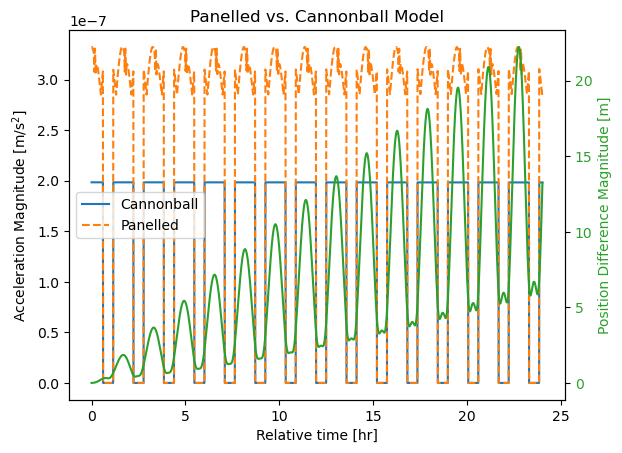

In [15]:
fig, ax = plt.subplots()
ax.plot(relative_time_hours, acceleration_norm_cb, label="Cannonball")
ax.plot(relative_time_hours, acceleration_norm_np, linestyle="--", label="Panelled")

ax2 = ax.twinx()
ax2.plot(relative_time_hours, pos_norm, label="norm", color="tab:green")

ax.legend()

ax.set_xlabel("Relative time [hr]")
ax.set_ylabel("Acceleration Magnitude [$\mathrm{m}/\mathrm{s}^2$]")
ax2.set_ylabel("Position Difference Magnitude [m]", color="tab:green")
ax2.tick_params(axis="y", labelcolor="tab:green")

ax.set_title("Panelled vs. Cannonball Model")

### Acceleration difference in RSW components

To get a more intuitive understanding how the models are different, we also plot the difference in acceleration and position in the RSW frame centered on the cannonball spacecraft.
In this case, only the first 3.5 hours of the orbit are plotted (corresponding to roughly two orbital revolutions), as the pattern in the accelerations repeats once per orbit.

Text(0.5, 0.98, 'Panelled - Cannonball Differences in RSW Frame during first two orbits')

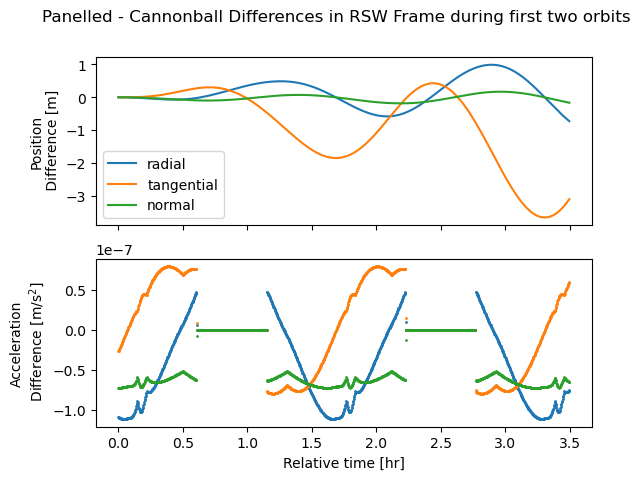

In [16]:
idx = np.searchsorted(relative_time_hours, 3.5)

fig, axs = plt.subplots(2, sharex=True)

axs[0].plot(
    relative_time_hours[:idx],
    nb_state_differences_rsw[:idx],
    label=["radial", "tangential", "normal"],
)

axs[1].scatter(
    relative_time_hours[:idx],
    acceleration_difference_rsw[:idx, 0],
    label="radial",
    s=1,
)
axs[1].scatter(
    relative_time_hours[:idx],
    acceleration_difference_rsw[:idx, 1],
    label="tangential",
    s=1,
)
axs[1].scatter(
    relative_time_hours[:idx],
    acceleration_difference_rsw[:idx, 2],
    label="normal",
    s=1,
)

axs[0].set_ylabel("Position\n Difference [m]")
axs[1].set_xlabel("Relative time [hr]")
axs[1].set_ylabel("Acceleration\n Difference [$\mathrm{m}/\mathrm{s}^2$]")

axs[0].legend()

fig.suptitle("Panelled - Cannonball Differences in RSW Frame during first two orbits")